In [1]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaWeightedMVFTS import PcaWeightedMVFTS
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Aux functions

In [2]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var='Global_active_power', dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Energy Appliance

In [5]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv'
data = pd.read_csv(filepath, sep = ";")
data = data.drop(labels=['Time','Date'], axis=1)
data.dropna(inplace = True)
data.head()


/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'],errors='coerce')
data['Global_reactive_power'] = pd.to_numeric(data['Global_reactive_power'],errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'],errors='coerce')
data['Global_intensity'] = pd.to_numeric(data['Global_intensity'],errors='coerce')
data['Sub_metering_1'] = pd.to_numeric(data['Sub_metering_1'],errors='coerce')
data['Sub_metering_2'] = pd.to_numeric(data['Sub_metering_2'],errors='coerce')
data['Sub_metering_3'] = pd.to_numeric(data['Sub_metering_3'],errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049280 entries, 0 to 2075258
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 125.1 MB


In [7]:
# values = data.values
# values

### Dataset Household: columns

In [8]:
# cols = data.columns
# list_cols = list(cols)
# list_cols.append('Appliances_t+1')
# print(list_cols)

### Dataset Household: Preprocessing, Lag = 1, t+1

In [9]:
# frame as supervised learning
reframed = series_to_supervised_miso(data, 1, 1,endog_var='Global_active_power')
reframed.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5.360
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.374
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.388
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.666
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,3.520


In [10]:
data = pd.DataFrame(reframed)
data = clean_dataset(data)
data

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
1,4.216,0.418,234.84,18.4,0.0,1.0,17.0,5.360
2,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.374
3,5.374,0.498,233.29,23.0,0.0,2.0,17.0,5.388
4,5.388,0.502,233.74,23.0,0.0,1.0,17.0,3.666
5,3.666,0.528,235.68,15.8,0.0,1.0,17.0,3.520
...,...,...,...,...,...,...,...,...
2075254,0.946,0.000,240.33,4.0,0.0,0.0,0.0,0.946
2075255,0.946,0.000,240.43,4.0,0.0,0.0,0.0,0.944
2075256,0.944,0.000,240.00,4.0,0.0,0.0,0.0,0.938
2075257,0.938,0.000,239.82,3.8,0.0,0.0,0.0,0.934


## Model: PcaWeightedMVFTS - PCA-MVFTS

In [12]:
pca_wmvfts = PcaWeightedMVFTS(n_components = 3,
                       endogen_variable = 'Global_active_power(t-1)',
                       n_part = 50)

--------------------
training window 0
[ 17:46:20] getting statistics


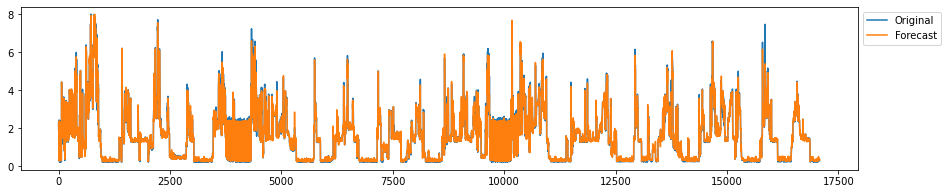

--------------------
training window 68309
[ 17:47:33] getting statistics


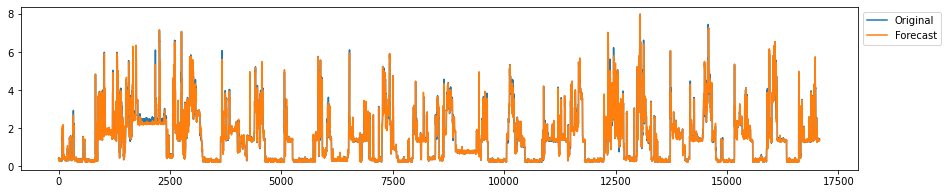

--------------------
training window 136618
[ 17:48:51] getting statistics


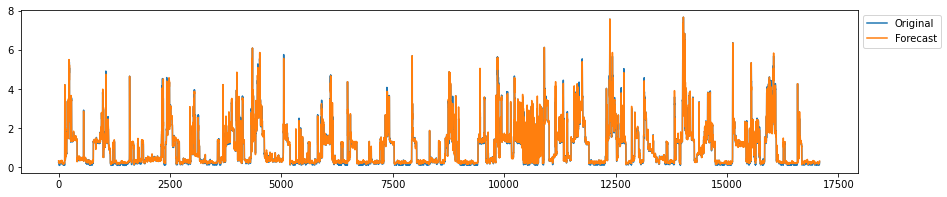

--------------------
training window 204927
[ 17:50:05] getting statistics


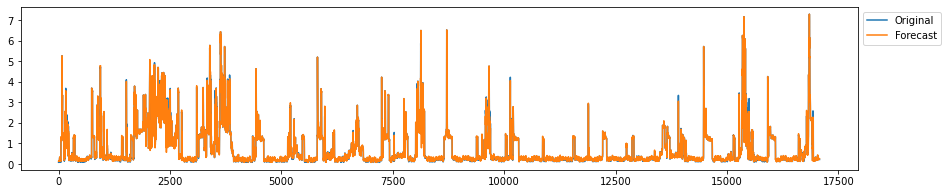

--------------------
training window 273236
[ 17:51:15] getting statistics


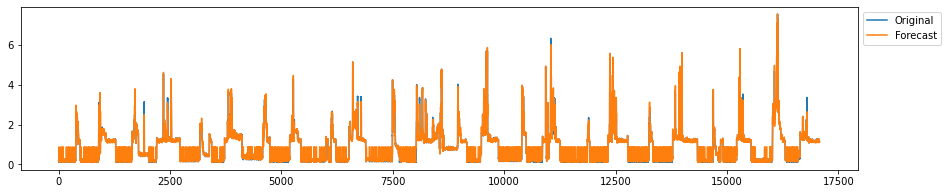

--------------------
training window 341545
[ 17:52:31] getting statistics


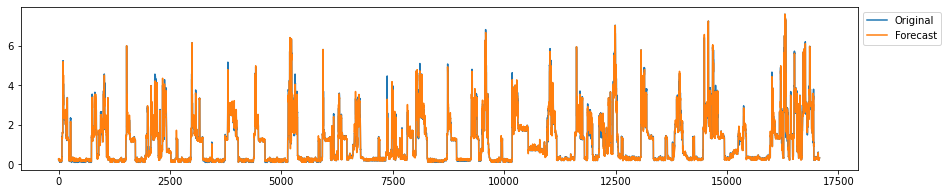

--------------------
training window 409854
[ 17:53:42] getting statistics


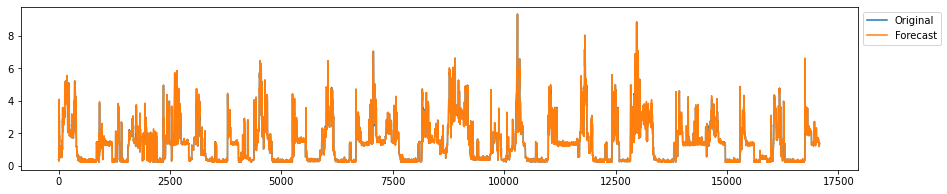

--------------------
training window 478163
[ 17:55:00] getting statistics


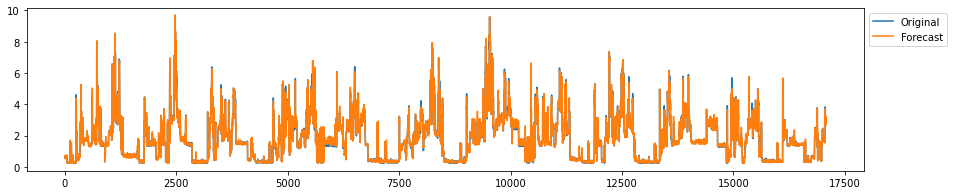

--------------------
training window 546472
[ 17:56:15] getting statistics


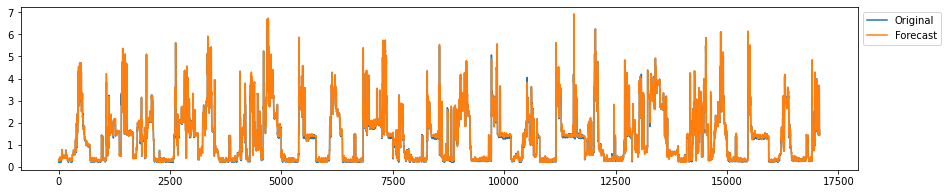

--------------------
training window 614781
[ 17:57:31] getting statistics


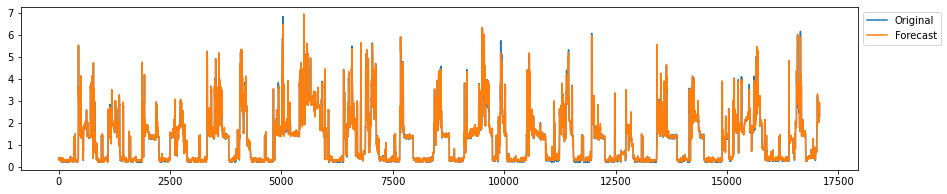

--------------------
training window 683090
[ 17:58:58] getting statistics


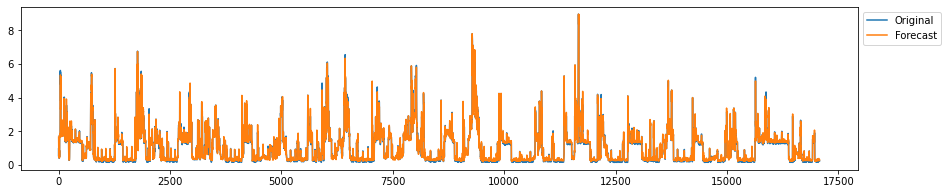

--------------------
training window 751399
[ 18:00:17] getting statistics


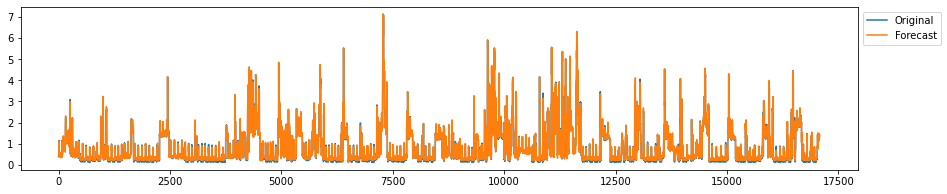

--------------------
training window 819708
[ 18:01:31] getting statistics


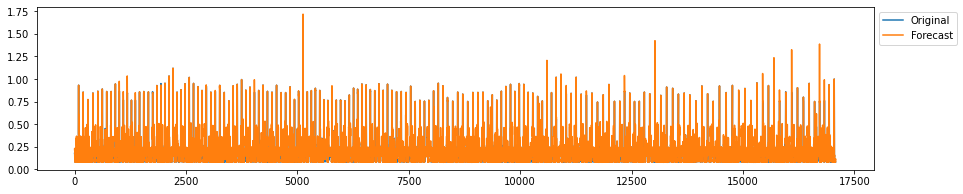

--------------------
training window 888017
[ 18:02:50] getting statistics


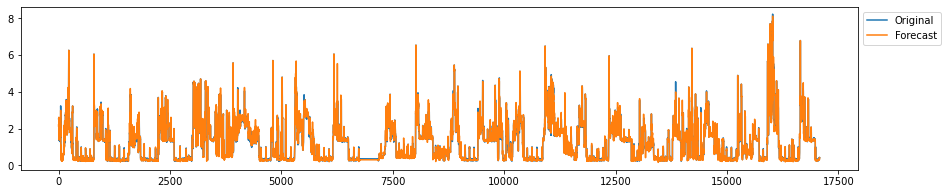

--------------------
training window 956326
[ 18:04:02] getting statistics


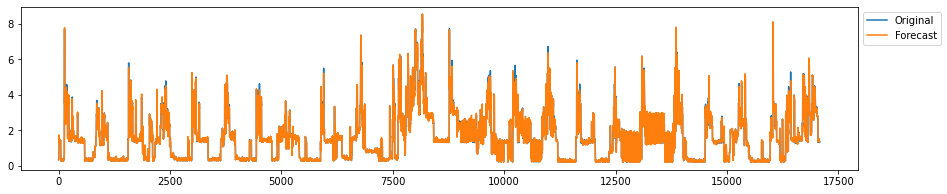

--------------------
training window 1024635
[ 18:05:19] getting statistics


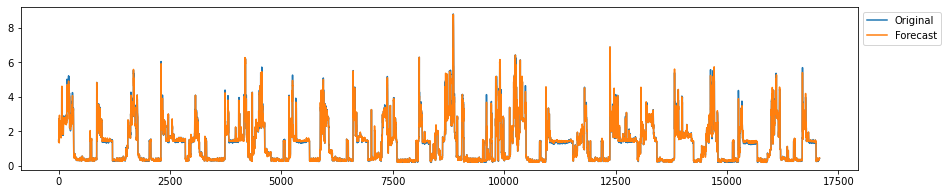

--------------------
training window 1092944
[ 18:06:40] getting statistics


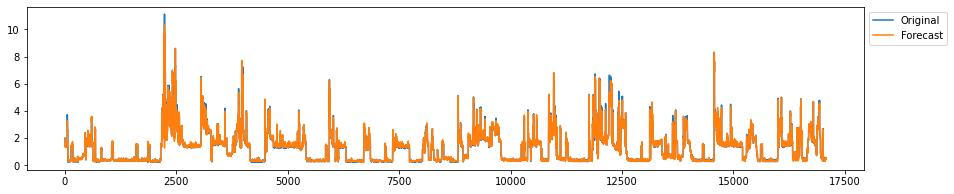

--------------------
training window 1161253
[ 18:08:02] getting statistics


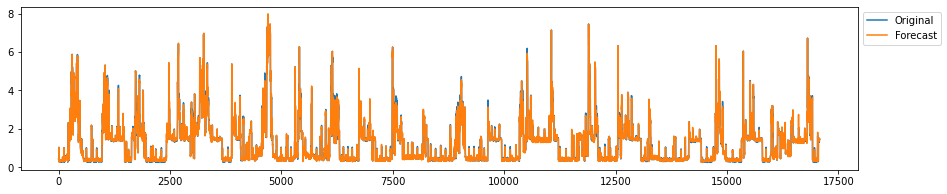

--------------------
training window 1229562
[ 18:09:19] getting statistics


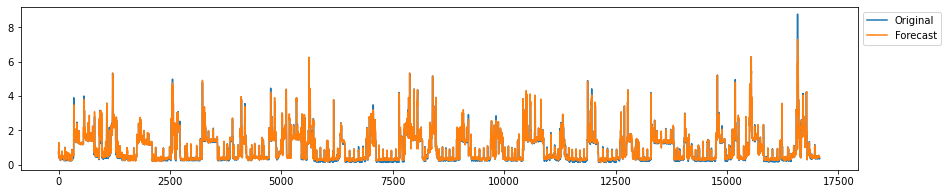

--------------------
training window 1297871
[ 18:10:34] getting statistics


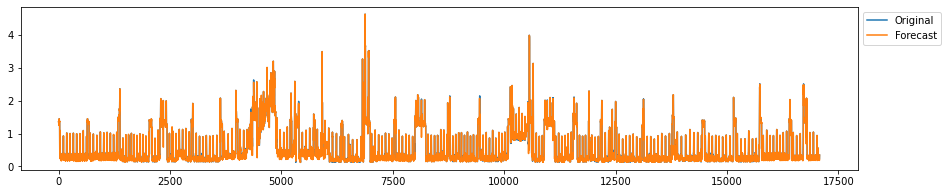

--------------------
training window 1366180
[ 18:11:55] getting statistics


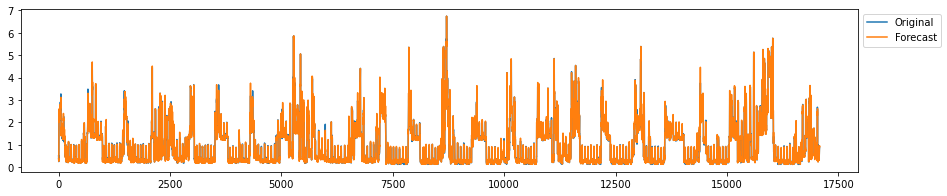

--------------------
training window 1434489
[ 18:13:20] getting statistics


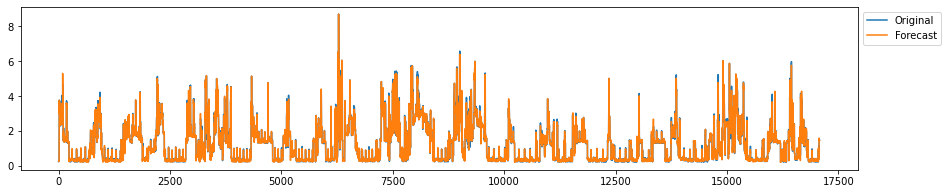

--------------------
training window 1502798
[ 18:14:45] getting statistics


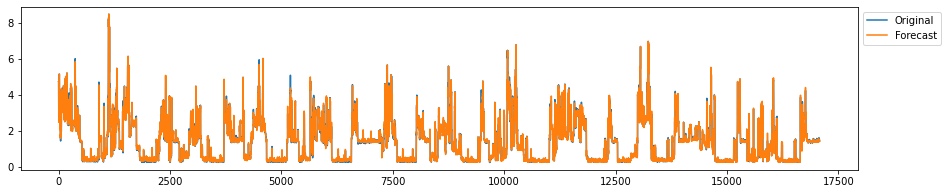

--------------------
training window 1571107
[ 18:15:59] getting statistics


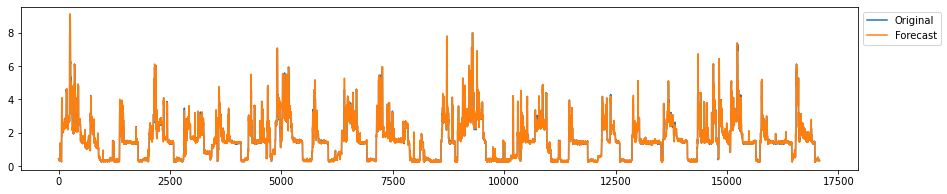

--------------------
training window 1639416
[ 18:17:22] getting statistics


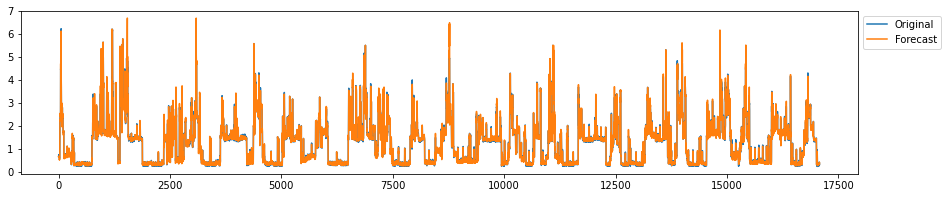

--------------------
training window 1707725
[ 18:18:44] getting statistics


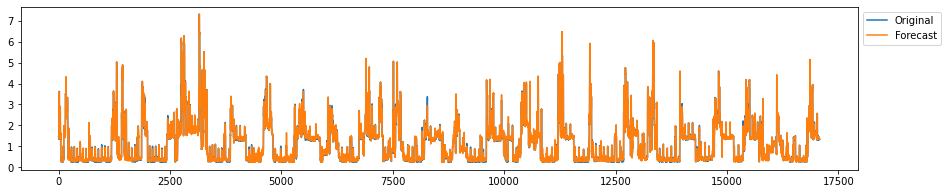

--------------------
training window 1776034
[ 18:20:03] getting statistics


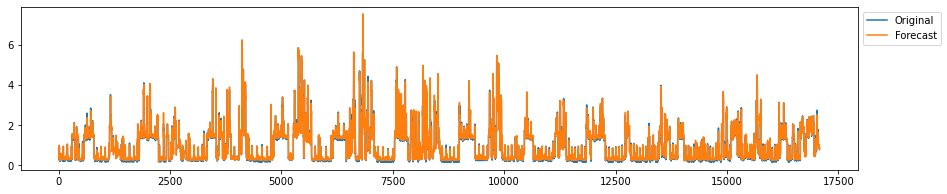

--------------------
training window 1844343
[ 18:21:18] getting statistics


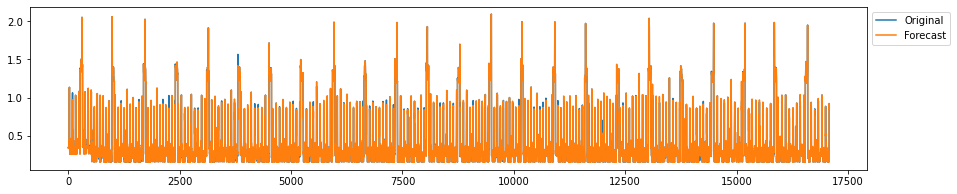

--------------------
training window 1912652
[ 18:22:43] getting statistics


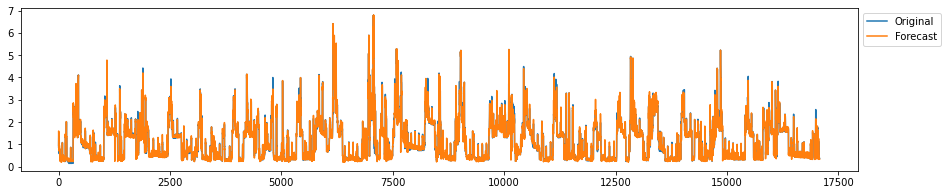

--------------------
training window 1980961
[ 18:24:08] getting statistics


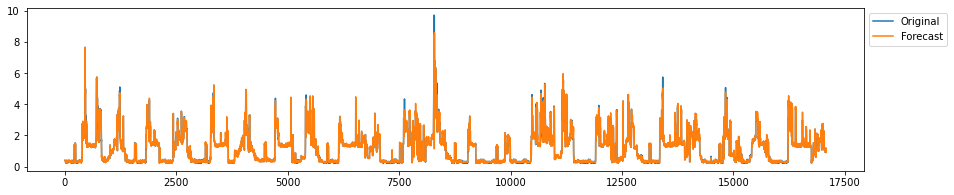

In [14]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        data_train = ttrain.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
        data_test = ttest.loc[:,'Global_reactive_power(t-1)':'Global_active_power(t)']
        
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'Global_active_power(t)': 'Global_reactive_power(t-1)'}, inplace = True)
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, pca_reduced_train = pca_wmvfts.run_train_model(data_train)
        forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,data_test)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        
        #Teste e cálculo dos erros da previsão  
        #valor use Global_reactive_power(t-1) é o Global_reactive_power(t) --> label igual por causa do modelo 
        rmse = Measures.rmse(pca_reduced_test['Global_active_power(t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Global_active_power(t-1)'], forecast)
        
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Global_active_power(t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        result["rmse"].append(round(rmse,3))
        result["mape"].append(round(mape,3))
        result["smape"].append(round(smape,3))
        result["mae"].append(round(mae,3))
        result["window"].append(ct)
        
measures = pd.DataFrame(result)



In [15]:
measures

,window,rmse,mae,mape,smape
0,0,0.122,0.066,7.742,3.497
1,68309,0.130,0.057,3.316,1.652
2,136618,0.097,0.055,14.744,6.180
3,204927,0.095,0.038,11.859,5.440
4,273236,0.090,0.138,1.485,0.719
5,341545,0.106,0.049,5.912,2.768
6,409854,0.083,0.025,1.276,0.623
7,478163,0.133,0.073,5.261,2.552
8,546472,0.064,0.036,5.132,2.418
9,614781,0.064,0.031,4.908,2.279


### Mean Statistics PCA-WMVFTS:

In [17]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))

        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-WMVFTS (test): ")
final_measures_pca

Mean Statistics PCA-WMVFTS (test): 


,rmse,mae,mape,smape
0,0.091,0.05,7.529,3.45


### Extras 

In [18]:
# pca_reduced_test

,C0,C1,Global_active_power(t)
0,-0.333878,-0.003297,0.408
1,-0.334188,-0.002439,0.406
2,-0.331482,0.011844,0.404
3,-0.331016,0.014420,0.404
4,-0.336717,-0.015486,0.400
...,...,...,...
17072,-0.308587,0.070867,0.948
17073,-0.301229,0.106276,1.198
17074,-0.290998,0.151979,1.024
17075,-0.301171,0.111941,0.946


In [34]:
# print(model)

Weighted Multivariate FTS:
v04,v114,Global_active_power(t)1 -> Global_active_power(t)1 (0.494), Global_active_power(t)2 (0.176), Global_active_power(t)0 (0.321), Global_active_power(t)3 (0.005), Global_active_power(t)4 (0.002), Global_active_power(t)5 (0.001), Global_active_power(t)6 (0.001), Global_active_power(t)7 (0.001), Global_active_power(t)8 (0.0), Global_active_power(t)13 (0.0), Global_active_power(t)14 (0.0), Global_active_power(t)9 (0.0)
v04,v114,Global_active_power(t)2 -> Global_active_power(t)1 (0.438), Global_active_power(t)2 (0.447), Global_active_power(t)0 (0.042), Global_active_power(t)3 (0.055), Global_active_power(t)4 (0.008), Global_active_power(t)5 (0.004), Global_active_power(t)6 (0.001), Global_active_power(t)13 (0.0), Global_active_power(t)14 (0.0), Global_active_power(t)15 (0.0), Global_active_power(t)7 (0.001), Global_active_power(t)8 (0.002), Global_active_power(t)19 (0.0), Global_active_power(t)20 (0.0), Global_active_power(t)9 (0.001), Global_active_power(t)

In [ ]:
# train = sample_first_prows(data,0.75)
# test = data.iloc[max(train.index):]
# y_test = data.iloc[max(train.index):]['Appliances_t+1'].values

In [ ]:
# pca_wmvfts = PcaWeightedMVFTS(n_components = 2,
#                        endogen_variable = 'Appliances_t+1',
#                        n_part = 50)

In [ ]:
# model, pca_reduced_train = pca_wmvfts.run_train_model(train)
# forecast, forecast_self, pca_reduced_test = pca_wmvfts.run_test_model(model,test)

In [ ]:
#model.mvflrg

In [ ]:
# forecast_1 = model.predict(pca_reduced_test)

In [ ]:
# Measures.rmse(y_test,forecast)

In [ ]:
# Measures.rmse(forecast_1,y_test)

In [ ]:
# Measures.rmse(y_test,forecast_self)

In [ ]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(y_test, label='Original')
# ax.plot(forecast, label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()


In [ ]:
# diff = data.loc[:,'lights':'Tdewpoint']
# diff = diff.diff()
# diff['Appliances'] = data['Appliances']
# data = diff.dropna()